In [240]:
!pip install torchnet
!pip install GitPython
!pip install python-git

In [0]:
from __future__ import print_function, division

import os
import git
import sys
import copy
import glob
import torch
import shutil
import tarfile
import scipy.io
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import skimage.transform
import numpy as np
import argparse
import pickle
import time
import math
import json

from pathlib import Path
from torchnet import meter
from torchvision import datasets, models, transforms
from torchvision.models import resnet50, resnet101, inception_v3
from urllib.request import urlretrieve
from matplotlib.pyplot import imshow
from torch.autograd import Variable
from PIL import ImageFile, Image
from torch import topk


In [0]:
# Download Stanford Dogs and split data into training and 
# test set according to the text files provided in:
# http://vision.stanford.edu/aditya86/ImageNetDogs/

if not os.path.exists("./DELTA"):
  !git clone https://github.com/lixingjian/DELTA.git

def get_list_mat(mat_file):
  file_list = scipy.io.loadmat(mat_file)["file_list"]
  l = []
  for f in file_list:
    l.append(f[0][0])

  return l

def move_images(image_list, dst, dataset, images_dir):
  for src in image_list:
    label = src[src.find("-")+1:src.rfind('/')].lower()
    shutil.copy(images_dir + src, dst + label)

def download_files(links):
  file_names = []
  for link in links:
    file_names.append(link.split("/")[-1])
    urlretrieve(link, file_names[-1])

  return file_names

def extract_files(files):
  for f in files:
    if f.endswith(".tar") or f.endswith(".tgz"):
      tar = tarfile.open(f)
      tar.extractall()
      tar.close()

def create_dir(directory):
  if isinstance(directory, list):
    for d in directory:
        Path(d).mkdir(parents=True, exist_ok=True)
  else:
    Path(directory).mkdir(parents=True, exist_ok=True)

def rm_stanford_files():
  os.remove("images.tar")
  os.remove("lists.tar")
  os.remove("file_list.mat")
  os.remove("train_list.mat")
  os.remove("test_list.mat")
  shutil.rmtree("Images")

dl_link = ["http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar",
           "http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar"]

dataset = "Stanford_Dogs"

files = download_files(dl_link)
extract_files(files)

images_dir = "./Images/"
dataset_dir = "DELTA/images/" + dataset + "/"
train_folder = dataset_dir + "train/"
test_folder = dataset_dir + "test/"

create_dir([dataset_dir, train_folder, test_folder])
class_folders = glob.glob(images_dir + "*")

labels = [f.split("/")[-1][f.split("/")[-1].find("-")+1:].lower() for f in class_folders]

for label in labels:
  create_dir(train_folder + label)
  create_dir(test_folder + label)

train_list = get_list_mat('train_list.mat')
test_list = get_list_mat('test_list.mat')

move_images(train_list, train_folder, dataset, images_dir)
move_images(test_list, test_folder, dataset, images_dir)

rm_stanford_files()


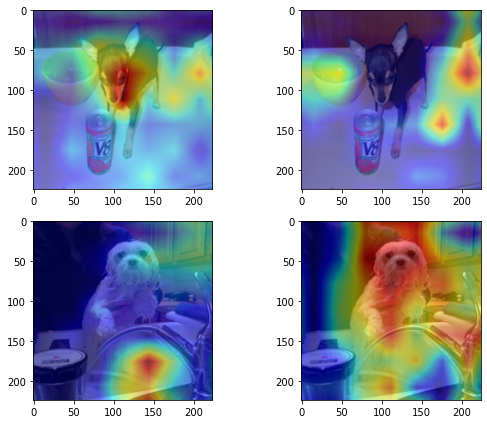

<Figure size 432x288 with 0 Axes>

In [243]:
# Display the activation mapping of some convolutional filters with low
# activation in the last layer for LS2P and DELTA

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])


idx = 0
att_map = []

def hook_function(module, grad_in, grad_out):
    for i in range((grad_out.shape[1])):
      if(i == idx):
        conv_output = grad_out.data[0, i]
        mx = torch.max(conv_output)
        mn = torch.min(conv_output)

        conv_output = (conv_output - mn) / (mx - mn)
        att_map.append(conv_output)

def set_att_map(model, img):
  layer = model._modules.get('layer4')
  hook = layer.register_forward_hook(hook_function)
  output = model(img)
  hook.remove() 

model = resnet101(pretrained=True)
model.fc = nn.Linear(2048, 120)
model.eval()

image_list = []

image1 = Image.open("DELTA/images/Stanford_Dogs/test/chihuahua/n02085620_2517.jpg")
image_list.append(preprocess(image1).unsqueeze(0))

image2 = Image.open("DELTA/images/Stanford_Dogs/test/maltese_dog/n02085936_3348.jpg")
image_list.append(preprocess(image2).unsqueeze(0))

for im in image_list:
  idx = 1919 # the low activation output filter chosen for DELTA
  model.load_state_dict(torch.load('weights/delta.weights', map_location=torch.device('cpu')))
  set_att_map(model, im)

  idx = 1757 # the low activation output filter chosen for L2SP
  model.load_state_dict(torch.load('weights/l2sp.weights', map_location=torch.device('cpu')))
  set_att_map(model, im)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
tensor = preprocess(image1)

ax[0][0].imshow(display_transform(image1))
ax[0][0].imshow(skimage.transform.resize(att_map[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');

ax[0][1].imshow(display_transform(image1))
ax[0][1].imshow(skimage.transform.resize(att_map[1], tensor.shape[1:3]), alpha=0.5, cmap='jet');

ax[1][0].imshow(display_transform(image2))
ax[1][0].imshow(skimage.transform.resize(att_map[2], tensor.shape[1:3]), alpha=0.5, cmap='jet');

ax[1][1].imshow(display_transform(image2))
ax[1][1].imshow(skimage.transform.resize(att_map[3], tensor.shape[1:3]), alpha=0.5, cmap='jet');

plt.tight_layout()
plt.show()

plt.savefig("act_map.png")


In [244]:
plt.savefig("act_map.png")

<Figure size 432x288 with 0 Axes>

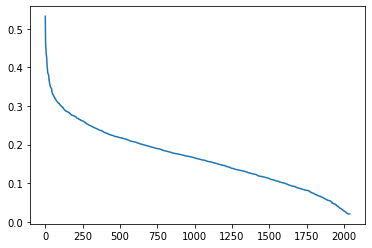

In [245]:

model = resnet101(pretrained=True)
model.fc = nn.Linear(2048, 120)
model.load_state_dict(torch.load('weights/l2sp.weights', map_location=torch.device('cpu')))
model.eval()

im = tensor.unsqueeze(0) # Dog Image
conv_1 = []

def hook_function(module, grad_in, grad_out):
    mean_list = []
    for i in range((grad_out.shape[1])):

        conv_output = grad_out.data[0, i]
        mx = torch.max(conv_output)
        mn = torch.min(conv_output)

        conv_output = (conv_output - mn) / (mx - mn)
        conv_1.append(conv_output)

        mean_list.append(conv_output.mean().item())

    # The distribution of the average activation values over all 
    # the 2048 filters of the last block using the L2SP weights
    plt.plot(-np.sort(-np.array(mean_list)))
    plt.show()

layer = model._modules.get('layer4')
hook = layer.register_forward_hook(hook_function)
output = model(im)

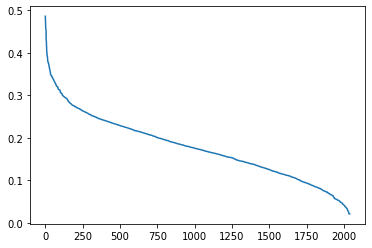

In [246]:

model = resnet101(pretrained=True)
model.fc = nn.Linear(2048, 120)
model.load_state_dict(torch.load('weights/delta.weights',map_location=torch.device('cpu')))
model.eval()

conv_2 = []
def hook_function(module, grad_in, grad_out):
    mean_list = []
    for i in range((grad_out.shape[1])):

        conv_output = grad_out.data[0, i]
        mx = torch.max(conv_output)
        mn = torch.min(conv_output)

        conv_output = (conv_output - mn) / (mx - mn)
        conv_2.append(conv_output)

        mean_list.append(conv_output.mean().item())

    # The distribution of the average activation values over all 
    # the 2048 filters of the last block using the delta weights
    plt.plot(-np.sort(-np.array(mean_list)))
    plt.show()
    
layer = model._modules.get('layer4')
hook = layer.register_forward_hook(hook_function)
output = model(im)

In [247]:
# The mean difference between the last layer of L2SP and DELTA 
distance = []

for i in range(len(conv_1)):
  distance += [np.linalg.norm(conv_2[i].mean().item() - conv_1[i].mean().item())]

# Output indices of the 10 largest distances
print(np.argsort(distance)[-10:])

[1868 1556 1469 2027 1217 1753   19 1285  378  753]


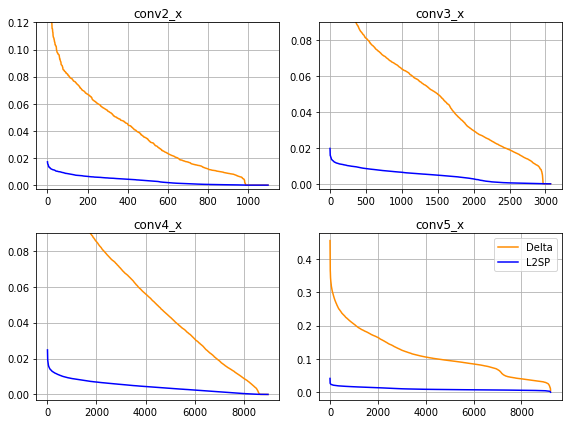

In [248]:
# Plot the sorted Euclidean distances of the Conv2D output filters between 
# the source model and the models with the regulisation: L2SP and DELTA

def get_model(path):
    model = resnet101(pretrained=True)
    model.fc = nn.Linear(2048, 120)
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    model.eval()

    return model

def get_distance(flattened_1, flattened_2):
    dist = copy.deepcopy(flattened_1)

    for i in range(flattened_1.shape[0]):
      for j in range(flattened_1[i].shape[0]):
        dist[i][j] = np.linalg.norm(flattened_1[i][j] - flattened_2[i][j])

    return np.array(dist)

def flatten_conv(block):
    flatten_list = []

    for bn in block:
      for name, layer in bn.named_modules():

        if "conv" in name:
          weight = layer.weight
          for i in range(weight.shape[0]):
            w = weight[i].view(weight[i].shape[0], -1)
            flatten_list.append(w.detach().numpy())

    return np.array(flatten_list)

def flatten_layer(model):
    layers = [model.layer1, model.layer2, model.layer3, model.layer4]

    flatten_layers = []
    for layer in layers:
        flatten_layers.append(flatten_conv(layer))

    return np.array(flatten_layers)

source = get_model("weights/source.weights")
delta_model = get_model("weights/delta.weights")
l2sp_model = get_model("weights/l2sp.weights")

source = flatten_layer(source)
delta_flatten = flatten_layer(delta_model)
l2sp_flatten = flatten_layer(l2sp_model)

delta_dist = get_distance(source, delta_flatten)
l2sp_dist = get_distance(source, l2sp_flatten)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))

ax[0][0].plot(-np.sort(-delta_dist[0][:1100]), color="darkorange")
ax[0][0].plot(-np.sort(-l2sp_dist[0][:1100]), color="blue")
ax[0][0].set_title("conv2_x")
ax[0][0].grid(True)

ax[0][1].plot(-np.sort(-delta_dist[1]), color="darkorange", label="Delta")
ax[0][1].plot(-np.sort(-l2sp_dist[1]), color="blue", label="L2SP")
ax[0][1].set_title("conv3_x")
ax[0][1].set_ylim(-0.003, 0.09)
ax[0][1].grid(True)

ax[1][0].plot(-np.sort(-delta_dist[2][:9000]), color="darkorange", label="Delta")
ax[1][0].plot(-np.sort(-l2sp_dist[2][:9000]), color="blue", label="L2SP")
ax[1][0].set_title("conv4_x")
ax[1][0].set_ylim(-0.003, 0.09)
ax[1][0].grid(True)

ax[1][1].plot(-np.sort(-delta_dist[3]), color="darkorange", label="Delta")
ax[1][1].plot(-np.sort(-l2sp_dist[3]), color="blue", label="L2SP")
ax[1][1].set_title("conv5_x")
ax[0][0].set_ylim(0, 0.3)
ax[1][1].legend()
ax[1][1].grid(True)

ax[0][0].set_ylim(-0.003, 0.12)

plt.tight_layout()
plt.savefig("distance_fig3.png")
plt.show()
